# Session 8: Rough Volatility

## Course: Advanced Volatility Modeling

---

## Learning Objectives

1. Understand fractional Brownian motion and the Hurst parameter
2. Explore the empirical evidence for rough volatility
3. Implement the rough Bergomi model
4. Connect rough volatility to realized volatility behavior

---

## 1. Motivation: Volatility is Rough

### 1.1 Classical vs Rough Volatility

**Classical SV** (Heston): Volatility driven by standard Brownian motion (H = 0.5)

**Rough Volatility** (Gatheral et al., 2018): Volatility driven by fractional Brownian motion with $H \approx 0.1$

### 1.2 Key Empirical Finding

$$E[|\log \sigma_{t+\Delta} - \log \sigma_t|^q] \propto \Delta^{qH}$$

with $H \approx 0.1$ across many assets!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

## 2. Fractional Brownian Motion

### 2.1 Definition

fBM $W^H_t$ with Hurst parameter $H \in (0,1)$:

$$\text{Cov}(W^H_s, W^H_t) = \frac{1}{2}(|s|^{2H} + |t|^{2H} - |t-s|^{2H})$$

| H value | Property |
|---------|----------|
| H < 0.5 | Rough, anti-persistent |
| H = 0.5 | Standard Brownian motion |
| H > 0.5 | Smooth, persistent |

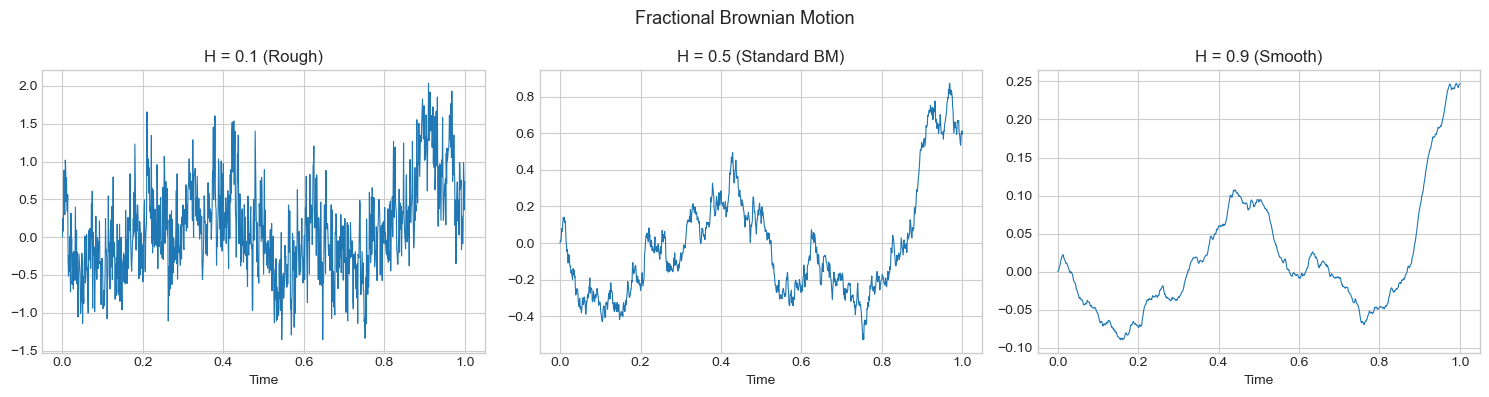

In [3]:
def simulate_fbm_cholesky(n, H, T=1, seed=None):
    """Simulate fBM using Cholesky decomposition."""
    if seed is not None:
        np.random.seed(seed)
    
    dt = T / n
    t = np.linspace(0, T, n + 1)
    
    # Build covariance matrix
    cov = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            ti, tj = (i + 1) * dt, (j + 1) * dt
            cov[i, j] = 0.5 * (ti**(2*H) + tj**(2*H) - abs(ti - tj)**(2*H))
    
    L = np.linalg.cholesky(cov + 1e-10 * np.eye(n))
    Z = np.random.standard_normal(n)
    W_H = np.zeros(n + 1)
    W_H[1:] = L @ Z
    
    return t, W_H

# Compare different H values
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, H in zip(axes, [0.1, 0.5, 0.9]):
    t, W = simulate_fbm_cholesky(1000, H, seed=42)
    ax.plot(t, W, linewidth=0.8)
    ax.set_title(f'H = {H} ({"Rough" if H < 0.5 else "Standard BM" if H == 0.5 else "Smooth"})')
    ax.set_xlabel('Time')

plt.suptitle('Fractional Brownian Motion', fontsize=13)
plt.tight_layout()
plt.show()

## 3. Estimating the Hurst Parameter

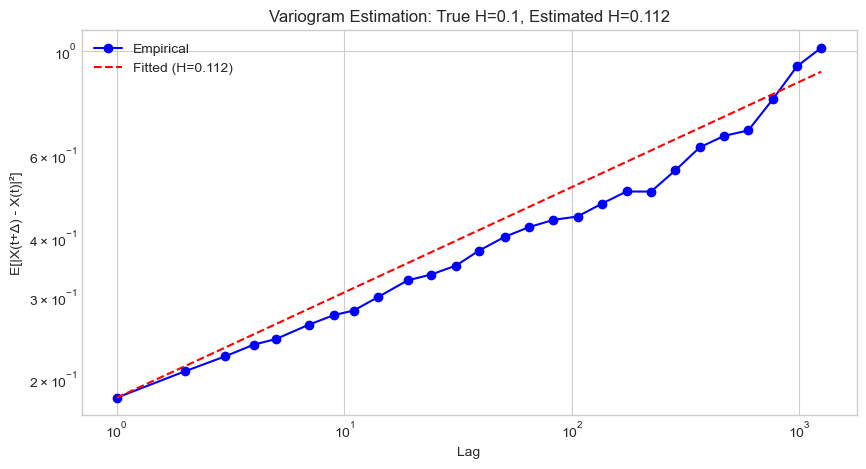

In [5]:
def estimate_hurst_variogram(x, q=2, max_lag=None):
    """Estimate Hurst parameter using variogram method."""
    n = len(x)
    if max_lag is None:
        max_lag = n // 4
    
    lags = np.unique(np.logspace(0, np.log10(max_lag), 30).astype(int))
    m_q = [np.mean(np.abs(x[lag:] - x[:-lag])**q) for lag in lags]
    
    # Log-log regression
    slope, _ = np.polyfit(np.log(lags), np.log(m_q), 1)
    H = slope / q
    
    return H, lags, np.array(m_q)

# Test on simulated fBM
true_H = 0.1
t, W_rough = simulate_fbm_cholesky(5000, true_H, seed=42)
H_est, lags, m_q = estimate_hurst_variogram(W_rough, q=2)

fig, ax = plt.subplots(figsize=(10, 5))
ax.loglog(lags, m_q, 'bo-', label='Empirical')
ax.loglog(lags, m_q[0] * (lags/lags[0])**(2*H_est), 'r--', 
          label=f'Fitted (H={H_est:.3f})')
ax.set_xlabel('Lag')
ax.set_ylabel('E[|X(t+Δ) - X(t)|²]')
ax.set_title(f'Variogram Estimation: True H={true_H}, Estimated H={H_est:.3f}')
ax.legend()
plt.show()

## 4. The Rough Bergomi Model

### 4.1 Model Specification (Bayer, Friz & Gatheral, 2016)

$$dS_t = S_t \sqrt{V_t} dW_t$$
$$V_t = \xi_0(t) \exp\left(\eta W_t^H - \frac{\eta^2}{2} t^{2H}\right)$$

where:
- $W^H_t$ is fractional Brownian motion with $H < 0.5$
- $\xi_0(t)$ is the forward variance curve
- $\eta$ controls vol-of-vol

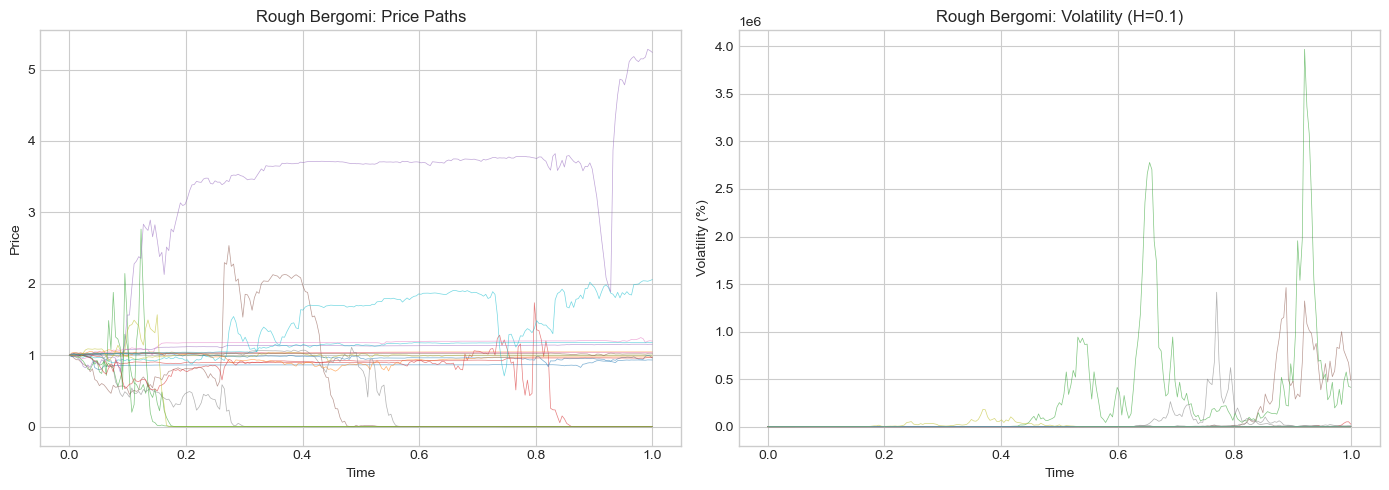

In [7]:
def simulate_rough_bergomi(n_paths, n_steps, T, H, eta, rho, xi0, S0=1, seed=None):
    """
    Simulate the rough Bergomi model.
    
    Parameters
    ----------
    n_paths : int
        Number of Monte Carlo paths
    n_steps : int
        Number of time steps
    T : float
        Time horizon
    H : float
        Hurst parameter
    eta : float
        Vol-of-vol
    rho : float
        Correlation between price and variance
    xi0 : float
        Initial forward variance (flat curve)
    """
    if seed is not None:
        np.random.seed(seed)
    
    dt = T / n_steps
    t = np.linspace(0, T, n_steps + 1)
    
    S = np.zeros((n_paths, n_steps + 1))
    V = np.zeros((n_paths, n_steps + 1))
    S[:, 0] = S0
    V[:, 0] = xi0
    
    for path in range(n_paths):
        # Generate fBM for this path (simplified using approximate method)
        dW_H = np.zeros(n_steps)
        for i in range(n_steps):
            # Approximate fBM increment (simplified)
            dW_H[i] = np.random.normal(0, dt**H)
        
        W_H = np.cumsum(dW_H)
        W_H = np.concatenate([[0], W_H])
        
        # Variance process
        for i in range(n_steps + 1):
            V[path, i] = xi0 * np.exp(eta * W_H[i] - 0.5 * eta**2 * t[i]**(2*H))
        
        # Price process
        for i in range(n_steps):
            Z = np.random.standard_normal()
            dW_S = rho * dW_H[i] / (dt**H) * np.sqrt(dt) + np.sqrt(1 - rho**2) * Z * np.sqrt(dt)
            S[path, i+1] = S[path, i] * np.exp(-0.5 * V[path, i] * dt + np.sqrt(V[path, i]) * dW_S)
    
    return t, S, V

# Simulate rough Bergomi
T = 1
n_steps = 252
n_paths = 100
H = 0.1
eta = 1.5
rho = -0.7
xi0 = 0.04

t, S, V = simulate_rough_bergomi(n_paths, n_steps, T, H, eta, rho, xi0, seed=42)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i in range(min(20, n_paths)):
    axes[0].plot(t, S[i], linewidth=0.5, alpha=0.6)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Price')
axes[0].set_title('Rough Bergomi: Price Paths')

for i in range(min(20, n_paths)):
    axes[1].plot(t, np.sqrt(V[i]) * 100, linewidth=0.5, alpha=0.6)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Volatility (%)')
axes[1].set_title(f'Rough Bergomi: Volatility (H={H})')

plt.tight_layout()
plt.show()

## 5. Empirical Evidence from Realized Volatility

In [9]:
def simulate_rv_series(n_days, H=0.1, base_vol=0.02, seed=None):
    """Simulate daily RV series with rough volatility."""
    if seed is not None:
        np.random.seed(seed)
    
    # Simulate log-volatility as fBM
    _, log_vol_fBm = simulate_fbm_cholesky(n_days, H, T=n_days/252, seed=seed)
    
    # Scale and exponentiate
    log_vol = np.log(base_vol) + 0.3 * log_vol_fBm
    rv = np.exp(2 * log_vol)  # Variance
    
    # Add measurement noise
    rv = rv * np.random.lognormal(0, 0.1, len(rv))
    
    return rv, log_vol

# Simulate and estimate H
n_days = 2500
true_H = 0.1

rv_rough, log_vol_rough = simulate_rv_series(n_days, H=true_H, seed=42)
H_est_rough, _, _ = estimate_hurst_variogram(np.log(rv_rough), q=2)

# Also simulate with standard H=0.5
rv_standard, log_vol_std = simulate_rv_series(n_days, H=0.5, seed=43)
H_est_std, _, _ = estimate_hurst_variogram(np.log(rv_standard), q=2)

print("Hurst Parameter Estimation from Log-RV")
print("="*50)
print(f"Rough volatility (true H={true_H}): Estimated H = {H_est_rough:.3f}")
print(f"Standard volatility (true H=0.5): Estimated H = {H_est_std:.3f}")

Hurst Parameter Estimation from Log-RV
Rough volatility (true H=0.1): Estimated H = 0.098
Standard volatility (true H=0.5): Estimated H = 0.287


## 6. Implications of Rough Volatility

### 6.1 For Option Pricing
- Better fit to implied volatility surface
- Explains short-term smile steepness

### 6.2 For Forecasting
- Very short-term persistence but rapid mean reversion
- Different from standard long-memory models

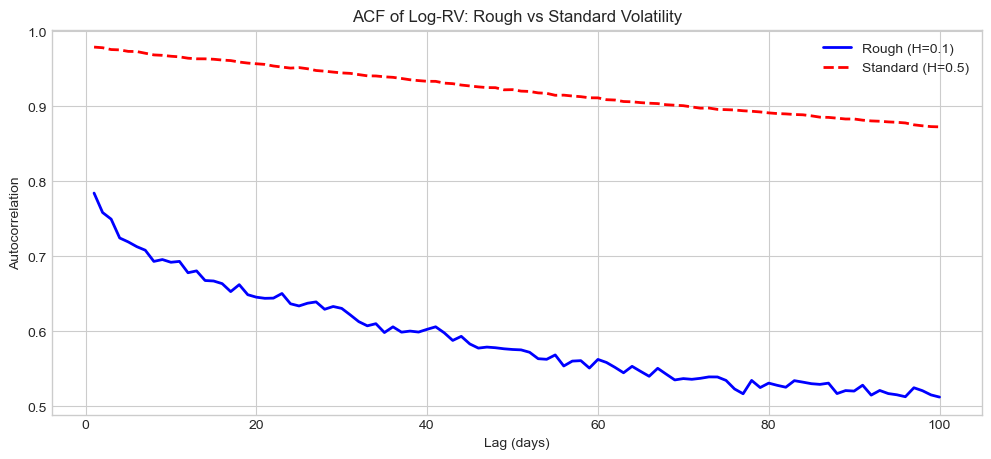


Rough volatility shows faster initial decay but longer persistence.


In [11]:
# Autocorrelation comparison
def compute_acf(x, max_lag=100):
    n = len(x)
    x = x - x.mean()
    acf = [np.corrcoef(x[:-lag], x[lag:])[0,1] for lag in range(1, max_lag+1)]
    return np.array(acf)

acf_rough = compute_acf(np.log(rv_rough), 100)
acf_std = compute_acf(np.log(rv_standard), 100)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(range(1, 101), acf_rough, 'b-', label=f'Rough (H={true_H})', linewidth=2)
ax.plot(range(1, 101), acf_std, 'r--', label='Standard (H=0.5)', linewidth=2)
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Autocorrelation')
ax.set_title('ACF of Log-RV: Rough vs Standard Volatility')
ax.legend()
plt.show()

print("\nRough volatility shows faster initial decay but longer persistence.")

## 7. Summary

### Key Takeaways

1. **Empirical finding**: H ≈ 0.1 across assets (much rougher than H=0.5)
2. **Fractional BM**: Driving process for rough volatility models
3. **Rough Bergomi**: Popular model for option pricing
4. **Implications**: Better option fit, different forecasting dynamics

### Preview: Session 9
Multivariate volatility models (DCC, BEKK).

## Exercises

1. Estimate H from real S&P 500 realized volatility data
2. Implement the rough Heston model
3. Compare option prices from Heston vs rough Bergomi
4. Investigate H across different asset classes (crypto, FX, commodities)

## References

1. Gatheral, J., Jaisson, T., & Rosenbaum, M. (2018). Volatility is rough. *Quantitative Finance*, 18(6), 933-949.
2. Bayer, C., Friz, P., & Gatheral, J. (2016). Pricing under rough volatility. *Quantitative Finance*, 16(6), 887-904.
3. Bennedsen, M., Lunde, A., & Pakkanen, M. S. (2022). Decoupling the short-and long-term behavior of stochastic volatility. *Journal of Financial Econometrics*, 20(5), 961-1006.